### Notebook to display pre-generated geomedian products

### Import required modules

In [121]:
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from datacube.storage import masking
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.interactive_maps import display_map

from datetime import datetime

import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

import odc
from odc.ui import to_png_data
from IPython.display import Image

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


## Initialise

In [118]:
dc = datacube.Datacube(app='geomedian')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [12]:
#set baseline start and end of period
baseline_start_date = '2018-1-1'
baseline_end_date = '2018-12-30'

#resolution - have this as a variable which can be changed. 
res = (10)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
platform = "SENTINEL_2"

aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

output_projection = "EPSG:3460"
crs = "EPSG:3460"

## Translate inputs

In [120]:
#time_range
#format dates

def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

In [14]:
#create resolution
resolution = (-res, res)

In [15]:
dask_chunks = dict(
    time = 1,
    x = 2000,
    y = 2000
)

In [16]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [17]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [18]:
# crs's for input parameters 
inProj  = Proj("+init=EPSG:4326")
#this is hard coded can it be related to crs variable above. 
outProj = Proj("+init=EPSG:3460")

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [19]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [20]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """Entry point for launching an IPython kernel.
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


In [21]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [25]:
allmeasurements = ["green","red","blue"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_geomedian_annual'
        measurements = allmeasurements
        ###CHANGE WHEN S2 WOFS READY
 
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements

In [26]:
product, measurement = create_product_measurement(platform)

## Load Data 

In [27]:
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': output_projection,
    'resolution': resolution,
    'time': baseline_time_period,
    'crs': crs,
    'dask_chunks': dask_chunks,
}

In [104]:
ds = dc.load(
    platform = platform,
    product = product,
    measurements = measurement,
    **query
)
ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 1567, y: 1138)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02
  * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
  * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06
    spatial_ref  int32 3460
Data variables:
    green        (time, y, x) int16 dask.array<chunksize=(1, 1138, 1567), meta=np.ndarray>
    red          (time, y, x) int16 dask.array<chunksize=(1, 1138, 1567), meta=np.ndarray>
    blue         (time, y, x) int16 dask.array<chunksize=(1, 1138, 1567), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [105]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


In [107]:
#delete unnecessary dimensions for rgb plotting
del ds["spatial_ref"]
del ds['time']
ds = ds.squeeze('time')

In [109]:
#compute dasked array 
ds = ds.compute()

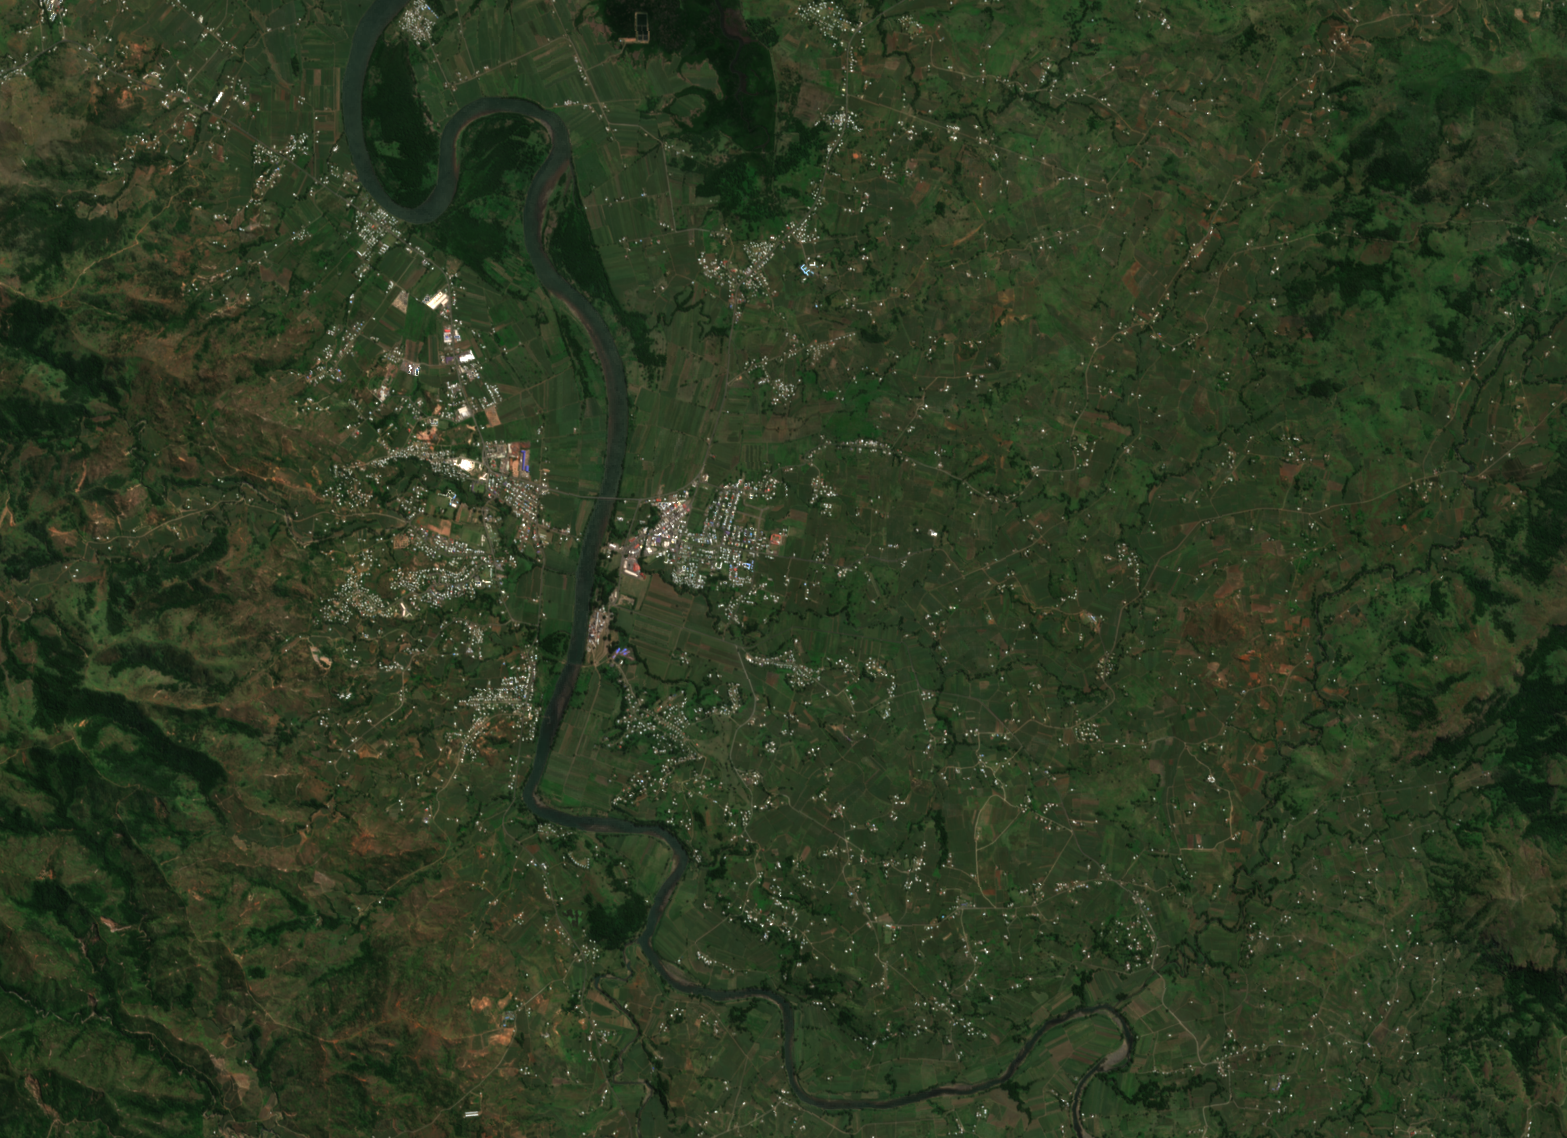

In [119]:
#plot as rgb
rgba = odc.algo.to_rgba(ds, clamp=3000)
Image(data=to_png_data(rgba.data))

---